## Legal Document Classifier

In [ ]:
#Import Libraries

In [1]:
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import BertTokenizer, BertModel
import torch
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re



In [219]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [383]:

data = '/content/drive/MyDrive/Work_project/sample_200_rows.csv'
mocked_data = '/content/drive/MyDrive/Work_project/mocked.csv'


In [347]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)

# Set model to evaluation mode
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [349]:
torch.cuda.is_available()

True

## Load Data

In [385]:
df = pd.read_csv(data)

In [389]:
df.head()

,case_title,suitno,introduction,facts,issues,decision,full_report
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.\n,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le..."
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri..."


In [390]:
df.shape

(200, 7)

Load mocked up data to handle rows with no law categories from intoduction

In [391]:
mocked_data = pd.read_csv(mocked_data)

In [392]:
mocked_data.head()

,Law Category,Related Terms
0,Constitutional Law,"['1999 Constitution', 'separation of powers', ..."
1,Administrative Law,"['judicial review', 'government agency', 'NAFD..."
2,Criminal Law,"['armed robbery', 'murder', 'theft', 'rape', '..."
3,Election Law,"['election petition', 'INEC', 'Electoral Act',..."
4,Enforcement of Fundamental Rights,"['fundamental rights', 'human dignity', 'freed..."


In [27]:
mocked_data['Related Terms'] = mocked_data['Related Terms'].apply(eval)

## Extract Labels 

We first remove strip out and remove unwanted characters from introduction field

In [28]:
df['introduction'] = df['introduction'].str.replace(r'[^A-Za-z0-9\s]', '', regex=True)  # Remove all non-alphanumeric except spaces
df['introduction'] = df['introduction'].str.replace(r'\s+', ' ', regex=True).str.strip()  # Normalize whitespace

This is where we start with the label extraction, in this code we search for patterns like "appeal border on XYZ" or "appeal borders XYZ" to extract the law types.

In [29]:
def handle_label_extraction(text):
    match = re.search(r'appeal borders?\s*(on)?\s+(.*)', text, re.IGNORECASE)
    if match:
        return match.group(2).strip()
    return ""

In [30]:
df['label1'] = df['introduction'].apply(handle_label_extraction)

We go further to write an helper function to handle all rows in introduction that has no categories but a certain data was provided. We use this data against the mockedup data to get their Law Category.

In [31]:
def handle_missing_label(text, label, df_mocked):
    # if not label:  # Check for missing label
    text_lower = text.lower()
    for _, row in df_mocked.iterrows():
        for term in row['Related Terms']:
             if term.lower() in text_lower:
                return row['Law Category']
             # elif term.lower() in



In [32]:
df['label2'] = df.apply(lambda row: handle_missing_label(row['introduction'], row['label1'], mocked_data)
                                                        if pd.isna(row['label1']) or row['label1'] == '' else row['label1'] , axis=1)

In [26]:
df.head(n=5)

,case_title,suitno,introduction,facts,issues,decision,full_report,label1,label2
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...",Civil Procedure,Civil Procedure
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,,Constitutional Law
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...",propriety of requirement of consent of the AG ...,propriety of requirement of consent of the AG ...
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Procedure,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le...",Criminal Law and Procedure,Criminal Law and Procedure
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri...",Enforcement of Fundamental Right to Liberty,Enforcement of Fundamental Right to Liberty


Here, we take all the labels extracted and validate them, so we don't have data like "This is a ruling on an application on a motion" in our labels and be sure we have processed all to their right law categories

In [33]:
def validate_law_categ(row, df_mocked, cols):
    label = row['label2']

    if isinstance(label, str) and label:
        label_lower = label.lower()
        known_categories = [str(categ).lower() for categ in df_mocked['Law Category'].dropna().tolist()]

        if not any(categ in label_lower for categ in known_categories):
            text = row[cols]
            return handle_missing_label(text, label_lower, df_mocked)
        else:
            return label
    else:
        return "No Value"





In [34]:
df['label3'] = df.apply(lambda row: validate_law_categ(row, mocked_data, 'introduction'), axis=1)

In [35]:
df.head(n=3)

,case_title,suitno,introduction,facts,issues,decision,full_report,label1,label2,label3
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...",Civil Procedure,Civil Procedure,Civil Procedure
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,,Civil Procedure,Civil Procedure
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...",propriety of requirement of consent of the AG ...,propriety of requirement of consent of the AG ...,Banking and Finance Law


In [403]:
# df['label3'] = df.apply(lambda row: handle_label_with_no_law_categ(row['introduction'], row['label1'], mocked_data),
#                                                                   axis=1)

To complete the label processing, we check for rows where we have empty values in our Label. Then, we fix it by using a combination of the introduction, facts and issues field to generate a label for them. 

In [36]:
df['combined_text'] = df['introduction'].fillna('') + ' ' + \
                      df['facts'].fillna('') + ' ' + \
                      df['issues'].fillna('')

In [37]:
df['Final_Label'] = df.apply(lambda row: validate_law_categ(row, mocked_data, 'combined_text')
                                if pd.isna(row['label3']) or row['label3'] == 'No Value' else row['label3'] , axis=1)

In [38]:
df.head(n=4)

,case_title,suitno,introduction,facts,issues,decision,full_report,label1,label2,label3,combined_text,Final_Label
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...",Civil Procedure,Civil Procedure,Civil Procedure,This appeal borders on Civil Procedure The app...,Civil Procedure
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,,Civil Procedure,Civil Procedure,This is a ruling on an Application seeking Lea...,Civil Procedure
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...",propriety of requirement of consent of the AG ...,propriety of requirement of consent of the AG ...,Banking and Finance Law,This appeal borders on propriety of requiremen...,Banking and Finance Law
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Procedure,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le...",Criminal Law and Procedure,Criminal Law and Procedure,Criminal Law and Procedure,This appeal borders on Criminal Law and Proced...,Criminal Law and Procedure


## Data Cleaning

The final label was cleaned up and values with inconsistent values were replaced

In [40]:
df['Final_Label'] = df['Final_Label'].str.lower().str.strip()

# Step 2: Replace all variations of the phrase with a consistent label
df['Final_Label'] = df['Final_Label'].replace({
    'the enforcement of fundamental rights': 'enforcement of fundamental rights',
    'enforcement of fundamental rights': 'enforcement of fundamental rights'
})

In [41]:
df['Final_Label'].value_counts()

civil procedure                      70
criminal law                         24
election law                         22
land law                             22
contract law                         19
criminal law and procedure            9
enforcement of fundamental rights     7
tort law                              6
labour law                            3
banking and finance law               3
family law                            2
constitutional law                    2
limitation law                        2
criminal procedure                    2
commercial law                        1
administrative law                    1
islamic law and procedure             1
property law                          1
succession and probate law            1
conveyancy law                        1
tax law                               1
Name: Final_Label, dtype: int64

In [42]:
df['Final_Label'].nunique()

21

We dropped fields we do not need here

In [43]:
df.drop(columns=['label1', 'label2', 'label3'], axis=1, inplace=True)

In [44]:
df.drop(columns=['combined_text'], axis=1, inplace=True)

Then we made our labels title case

In [410]:
df['Final_Label']=df['Final_Label'].str.title()

Here, we take values in labels that has low counts and merge it with closely related values.

In [413]:
df['normalized_label'] = df['Final_Label'].replace({
    'Criminal Procedure': 'Criminal Law And Procedure',
    'Conveyancy Law': 'Property Law',
    'Limitation Law': 'Civil Procedure'
})

Now, we go further with our data cleaning. We take the full_report field which is our interested field to build our model. 
We clean the data to replace all leading and trailing whitespace and ensure it's in readable format

In [424]:
def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text).replace("&nbsp;", " ").strip()

In [425]:
df["clean_full_report"] = df["full_report"].apply(clean_text)

In [153]:
df.head(n=3)

,case_title,suitno,introduction,facts,issues,decision,full_report,normalized_label,combined_text,clean_full_report
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...",Civil Procedure,This appeal borders on Civil Procedure The app...,"GEORGE ADESOLA OGUNTADE, J.C.A. (Delivering th..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,Civil Procedure,This is a ruling on an Application seeking Lea...,CHIOMA EGONDU NWOSU-IHEME J.C.A. (Delivering ...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...",Banking And Finance Law,This appeal borders on propriety of requiremen...,"PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ..."


## Data Chunking & Tokenization

This project makes use of DistilBERT to generate embeddings for the text classification, and tokenization.

In this stage, we first carry out tokenization on the full_report field, so as to break the text into subword tokens. We also did chunking right after that to prevent information loss on our text. DistilBERT do have a maximum input length of 512 tokens, and looking at our text we definitley have to chunk.



In [427]:
def chunk_text(text, chunk_size=512):
    """
    Tokenizes the text and splits it into chunks of max 512 tokens each prepended with [CLS] and appended with [SEP].
    """
    # Tokenize the full text
    tokens = tokenizer.tokenize(text)

    # Divide into chunks 
    chunks = [tokens[i:i + chunk_size - 2] for i in range(0, len(tokens), chunk_size - 2)]

    # Add [CLS] and [SEP] tokens to each chunk
    return [['[CLS]'] + chunk + ['[SEP]'] for chunk in chunks]


In [428]:
texts = df['clean_full_report'].fillna("").tolist()

## BERT Embeddings

This is where we generate embeddings for each chunk. We pass our data input through the pre-trained BERT model and extract the embedding from it.

In [429]:
def embed_chunks(chunks):
    """
    Computes the average [CLS] embedding across all chunks of a document.
    """
    chunk_embeddings = []

    for chunk in chunks:
        # Convert tokens to IDs
        input_ids = tokenizer.convert_tokens_to_ids(chunk)

        # Convert to tensor and add batch dimension
        input_tensor = torch.tensor([input_ids]).to(device)  
        with torch.no_grad():
            outputs = model(input_tensor)

            # Extract the [CLS] embedding (first token in sequence)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            chunk_embeddings.append(cls_embedding.squeeze().cpu().numpy())

    # Average embeddings from all chunks
    return np.mean(chunk_embeddings, axis=0)


We pass in both function for getting embeddings and chunking text here

In [430]:
def get_embedding(text):
    """
    Tokenizes and computes BERT embedding for an entire document.

    Args:
        text (str): The full input document text.

    Returns:
        np.array: Document-level embedding vector (average of all chunk [CLS] vectors).
    """
    chunks = chunk_text(text)
    return embed_chunks(chunks)


This is where we call the function to generate our embeddings

In [431]:
embeddings = np.array([get_embedding(text) for text in texts])

## Label Encoding

Now that we’ve obtained the embedding vectors for our input features, we also need to prepare the target labels for model training. Below, we convert the target field into numerical format using label encoding.

In [433]:
from sklearn.preprocessing import LabelEncoder
labels = df['normalized_label'].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

## Build Model

This is where we build our model to classify the different law categories.

In [434]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight



from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [435]:
 X_train, X_test, y_train, y_test = train_test_split( embeddings, y, test_size=0.2, random_state=42, stratify=y
 )

### Handle Imbalanced Class with Class Weight

First, we need to address the class imbalance in our multi-class labels. This step is important for improving model performance and also to prevent our model from favoring classes with more data while neglecting underrepresented ones.

We use the class weighting technique to tackle this.

In [436]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

### Model Evaluation

This helper function is used to provide model evaluation results.Through this, we get the accuracy score, precision, recall, f1 and the confusion matrix result

In [437]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)


    print(f"Accuracy score on Testing Data is:", score)
    print("\n-------------------------------------------------")
    print(f"Precision score on Testing Data is:", precision)
    print(f"Recall score on Testing Data is:", recall)
    print(f"F1 score of  on Testing Data is:", f1)

    print("\n-------------------------------------------------")
    print("Confusion Matrix is:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### Random Forest Classifier

Below is where we train our RandomForestClassifier. We make sure to pass in the computed class_weight values, along with some additional parameters for model training.

In [438]:
rf = RandomForestClassifier(n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=class_weight_dict,
    random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={np.int64(0): np.float64(2.2444444444444445),
                                     np.int64(1): np.float64(1.8703703703703705),
                                     np.int64(2): np.float64(0.1968810916179337),
                                     np.int64(3): np.float64(1.8703703703703705),
                                     np.int64(4): np.float64(1.8703703703703705),
                                     np.int64(5): np.float64(0.7481481481481481),
                                     np.int64(6): np.float64(0.5906432748538012),
                                     np.int64(7):...
                                     np.int64(12): np.float64(1.8703703703703705),
                                     np.int64(13): np.float64(0.6601307189542484),
                                     np.int64(14): np.float64(1.8703703703703705),
                                     np.int64(15): np.float64(1.8703703703703705),
                                     np.int64(16): np.float64(2.2444444444444445),
                                     np.int64(17): np.float64(2.2444444444444445)},
                       max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

Accuracy score on Testing Data is: 60.78431372549019

-------------------------------------------------
Precision score on Testing Data is: 0.5718954248366013
Recall score on Testing Data is: 0.6078431372549019
F1 score of  on Testing Data is: 0.5586986732677568

-------------------------------------------------
Confusion Matrix is:


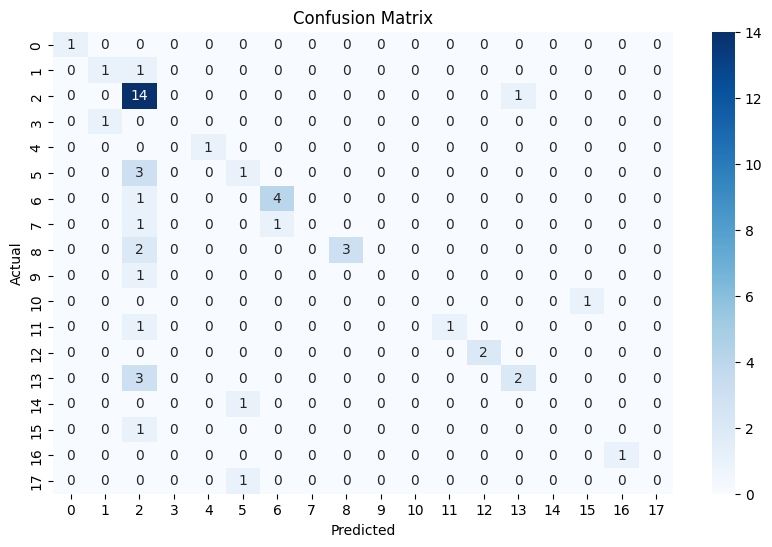

In [439]:
evaluate_model(rf, X_test, y_test)

In our result above, for the precision, our model was able get 57% correct out of all predicitons for the positive class.
While on the recall, the model correctly identified about 61% of the actual positive instances.


### Support Vector Machine

The support vector machine algorithm was used here to train the model.

In [440]:
svc = SVC(
    kernel='linear',
    C=1.0,
    class_weight=class_weight_dict,
    random_state=42
)
svc.fit(X_train, y_train)

SVC(class_weight={np.int64(0): np.float64(2.2444444444444445),
                  np.int64(1): np.float64(1.8703703703703705),
                  np.int64(2): np.float64(0.1968810916179337),
                  np.int64(3): np.float64(1.8703703703703705),
                  np.int64(4): np.float64(1.8703703703703705),
                  np.int64(5): np.float64(0.7481481481481481),
                  np.int64(6): np.float64(0.5906432748538012),
                  np.int64(7): np.float64(1.246913...
                  np.int64(10): np.float64(1.8703703703703705),
                  np.int64(11): np.float64(2.2444444444444445),
                  np.int64(12): np.float64(1.8703703703703705),
                  np.int64(13): np.float64(0.6601307189542484),
                  np.int64(14): np.float64(1.8703703703703705),
                  np.int64(15): np.float64(1.8703703703703705),
                  np.int64(16): np.float64(2.2444444444444445),
                  np.int64(17): np.float64(2.2444444444444445)},
    kernel='linear', random_state=42)

Accuracy score on Testing Data is: 64.70588235294117

-------------------------------------------------
Precision score on Testing Data is: 0.6400560224089635
Recall score on Testing Data is: 0.6470588235294118
F1 score of  on Testing Data is: 0.6311348781937017

-------------------------------------------------
Confusion Matrix is:


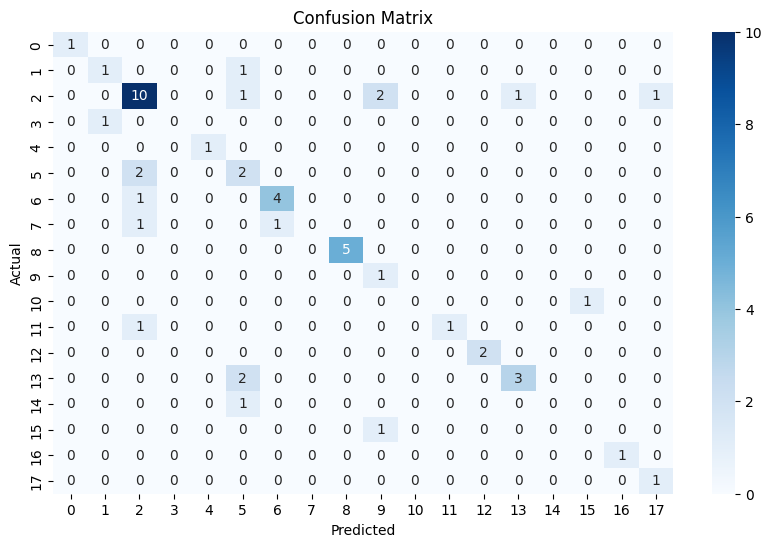

In [441]:
evaluate_model(svc, X_test, y_test)

In our result, for the precision, our model was able get 64% correct out of all predicitons for the positive class. While on the recall, the model correctly identified about 65% of the actual positive instances.This algorithm performed more better than the Random Forest Classifier.

### ExtraTreesClassifier

We went further to test with more tree based models to compare performance

In [442]:
ET = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=42
)
ET.fit(X_train, y_train)


ExtraTreesClassifier(class_weight={np.int64(0): np.float64(2.2444444444444445),
                                   np.int64(1): np.float64(1.8703703703703705),
                                   np.int64(2): np.float64(0.1968810916179337),
                                   np.int64(3): np.float64(1.8703703703703705),
                                   np.int64(4): np.float64(1.8703703703703705),
                                   np.int64(5): np.float64(0.7481481481481481),
                                   np.int64(6): np.float64(0.5906432748538012),
                                   np.int64(7): np...
                                   np.int64(12): np.float64(1.8703703703703705),
                                   np.int64(13): np.float64(0.6601307189542484),
                                   np.int64(14): np.float64(1.8703703703703705),
                                   np.int64(15): np.float64(1.8703703703703705),
                                   np.int64(16): np.float64(2.2444444444444445),
                                   np.int64(17): np.float64(2.2444444444444445)},
                     max_depth=20, min_samples_leaf=2, min_samples_split=5,
                     n_estimators=200, n_jobs=-1, random_state=42)

Accuracy score on Testing Data is: 64.70588235294117

-------------------------------------------------
Precision score on Testing Data is: 0.6084373143196673
Recall score on Testing Data is: 0.6470588235294118
F1 score of  on Testing Data is: 0.6096184419713832

-------------------------------------------------
Confusion Matrix is:


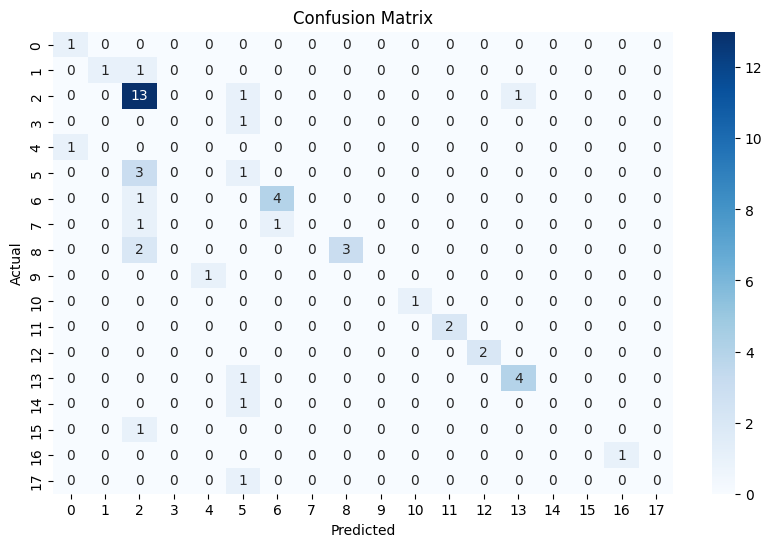

In [443]:
evaluate_model(ET, X_test, y_test)

In the result above, for the precision, our model was able get 61% correct out of all predicitons for the positive class. While on the recall, the model correctly identified about 65% of the actual positive instances.

### CatBoost Classifier

The final algorithm used is the Catboost algorithm

In [446]:
# %pip install catboost

In [447]:
classes = np.unique(y_train)
catboost_class_weights = [class_weight_dict[label] for label in classes]


catboost_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    class_weights=catboost_class_weights,
    loss_function='MultiClass',
    verbose=False,
    random_seed=42
)

catboost_model.fit(X_train, y_train)


Accuracy score on Testing Data is: 68.62745098039215

-------------------------------------------------
Precision score on Testing Data is: 0.6160130718954249
Recall score on Testing Data is: 0.6862745098039216
F1 score of  on Testing Data is: 0.6459383753501401

-------------------------------------------------
Confusion Matrix is:


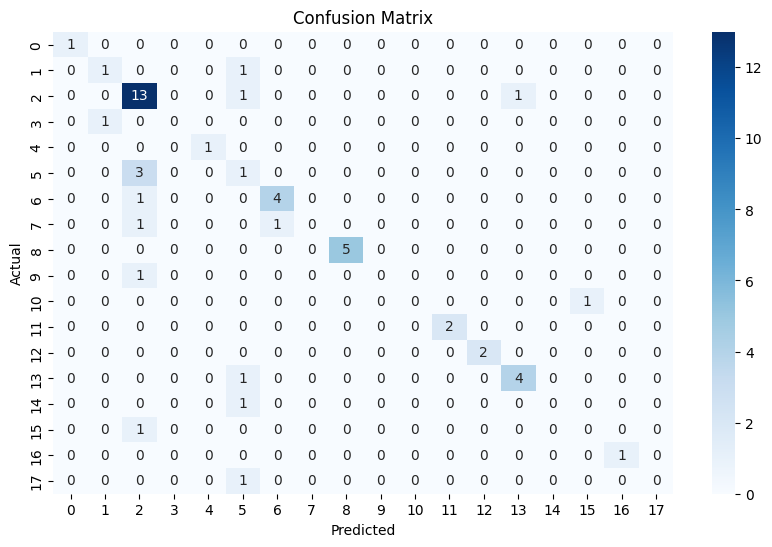

In [448]:
evaluate_model(catboost_model, X_test, y_test)

In our result, for the precision, our model was able get 62% correct out of all predicitons for the positive class. While on the recall, the model correctly identified about 69% of the actual positive instances.The F1 Score is slightly higher than that of the Support Vector Machine. 

So, we saved this model and the encoder

In [449]:


joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [450]:

joblib.dump(catboost_model, "model.pkl")

['model.pkl']

## Model Testing With Fresh Data

In this stage, we test the model performace by sending new data to the model.

#### Load pre-trained DistilBERT tokenizer and model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)

#### Load trained classifier and label encoder

In [49]:
import joblib
cat_model = joblib.load("model.pkl")
label_encoder = joblib.load("label_encoder.pkl")

#### Tokenize and get Embeddings

We pass the new data through all pre-processing steps we did while training the model. So, we can get the embeddings vectors from it.

In [50]:
def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text).replace("&nbsp;", " ").strip()

def chunk_text(text, chunk_size=512):
    tokens = tokenizer.tokenize(text)
    chunks = [tokens[i:i + chunk_size - 2] for i in range(0, len(tokens), chunk_size - 2)]
    return [['[CLS]'] + chunk + ['[SEP]'] for chunk in chunks]

def embed_chunks(chunks):
    chunk_embeddings = []
    for chunk in chunks:
        input_ids = tokenizer.convert_tokens_to_ids(chunk)
        input_tensor = torch.tensor([input_ids]).to(device)

        with torch.no_grad():
            outputs = bert_model(input_tensor)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            chunk_embeddings.append(cls_embedding.squeeze().cpu().numpy())

    return np.mean(chunk_embeddings, axis=0)

def get_embedding(text):
    chunks = chunk_text(text)
    return embed_chunks(chunks)


#### Predict Law Types

In [51]:

def predict_new_cases(df_new):
    # Step 1: Clean the input
    df_new['clean_full_report'] = df_new['full_report'].apply(clean_text)

    # Step 2: Generate embeddings
    embeddings = np.array([get_embedding(text) for text in df_new['clean_full_report']])

    # Step 3: Predict
    y_pred = cat_model.predict(embeddings)
    
    # Step 4: Decode labels 
    if label_encoder:
        df_new['predicted_label'] = label_encoder.inverse_transform(y_pred)
    else:
        df_new['predicted_label'] = y_pred

    return df_new[['case_title', 'predicted_label']]


In [52]:
sample = '/content/drive/MyDrive/Work_project/sample.csv'
df_new_cases = pd.read_csv(sample)

In [53]:
df_new_cases

,case_title,suitno,introduction,facts,issues,decision,full_report
0,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","ADEDAYO OKONJO, J.C.A. (Delivering the Leading..."
1,ZENITH BANK PLC v. BENUE STATE URBAN DEVELOPME...,CA/MK/248/2013,This appeal borders on Civil Procedure.\n,This is an appeal against the ruling of the Hi...,The Court determined the appeal on the Prelimi...,"On the whole, the Court found merit in the Res...","JUSTICE CHINEDU ADIGWE, J.C.A. (Delivering the..."
2,NURA KABIRU v. THE STATE,CA/KN/17C/C/2020,This appeal borders on the offence of Acts of ...,The Appellant was arraigned with others as the...,The appeal was resolved on this sole issue:Whe...,"In the final analysis, the appeal was allowed....","JUSTICE NKECHI O. OKPARA, J.C.A. (Delivering t..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n",Between:\nENGR. USMAN ABDULMALIK (Candidate of...
4,BAKA JIJI & ANOR v. IBRAHIM ABARE,CA/J/98S/94,This appeal borders on the jurisdiction of the...,The respondent sued the appellants before the ...,"The issue for determination is:""Whether the Sh...","In the final analysis, the Court of Appeal all...",Between:\nMOUNTAIN CREST POWER LIMITED – Appel...


df_new_cases

In [54]:
# Predict
results = predict_new_cases(df_new_cases)
print(results)

                                          case_title          predicted_label
0  CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...  Banking And Finance Law
1  ZENITH BANK PLC v. BENUE STATE URBAN DEVELOPME...               Family Law
2                           NURA KABIRU v. THE STATE             Property Law
3  MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...             Election Law
4                  BAKA JIJI & ANOR v. IBRAHIM ABARE                  Tax Law


In [466]:
len(results)

3